## LG AI 해커톤, 블럭 장난감 제조 공정 최적화 AI경진대회
## 제발류 (팀명)
## 2020년 07월 03일 (제출날짜)

### 코드 제출 규칙

- 입상자는 데이콘에서 안내한 양식에 맞추어 코드 제출

- R user는 R or .rmd. Python user는 .py or .ipynb로 제출

- 코드에 ‘/data’ 데이터 입/출력 경로 포함

- 전체 프로세스를 가독성 있게 정리하여 주석 포함 하나의 파일로 제출

- 제출 코드는 리더보드 점수를 복원할 수 있어야 함

- 모든 코드는 오류 없이 실행되어야 함 (라이브러리 로딩 코드 포함)

- 코드와 주석의 인코딩은 UTF-8 사용

- AI 모델을 사용해야 함

* AI 모델 학습 과정이 있어야 함

* Gurobi, FICO 등 상용 솔루션 사용 불가

## 1. 라이브러리 및 데이터
## Library & Data

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
import os
from module.genome import Genome, genome_score
warnings.filterwarnings(action='ignore')
np.random.seed(76) # 랜덤 시드 고정

# 필요 데이터 로드
path = 'module/'
order = pd.read_csv(path + 'order.csv')
stock = pd.read_csv(path + 'stock.csv')
max_count = pd.read_csv(path + 'max_count.csv')

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

## 3. 탐색적 자료분석
## Exploratory Data Analysis

### 데이터 파일 확인

#### 1. order.csv
필요한 장난감 수요 확인

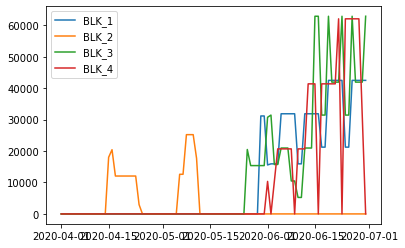

Order of BLK_1:  986353
Order of BLK_2:  244424
Order of BLK_3:  1103274
Order of BLK_4:  921032


In [3]:
order = pd.read_csv(path + 'order.csv')
time = pd.to_datetime(order['time'])

plt.figure()
plt.plot(time, order.loc[:,'BLK_1':'BLK_4'])
plt.legend(order.columns[1:])
plt.show()

print('Order of BLK_1: ',order['BLK_1'].sum())
print('Order of BLK_2: ',order['BLK_2'].sum())
print('Order of BLK_3: ',order['BLK_3'].sum())
print('Order of BLK_4: ',order['BLK_4'].sum())

BLK_2는 초반에, 나머지는 후반부에 필요하고 BLK_2는 다른 제품에 비해 수요가 적음

#### 2. max_count.csv
일별 최대 생산량 확인

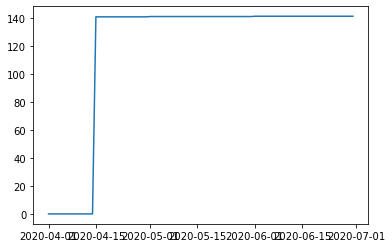

In [4]:
plt.figure()
plt.plot(time, max_count['count'])
plt.show()

4월 14일 이후부터 생산이 가능

#### 3. stock.csv
장난감 재고 확인

In [5]:
stock.head()

,PRT_1,PRT_2,PRT_3,PRT_4,MOL_1,MOL_2,MOL_3,MOL_4,BLK_1,BLK_2,BLK_3,BLK_4
0,0,258,0,0,1086,0,0,0,61158,87279,0,0


PRT의 초기 재고가 2번 장난감밖에 없기 때문에 초반 23일동안은 2번만 생산 가능

### global max score 예상

In [6]:
# 현재 재고로 생산 가능한 최대 제품 개수 확인 (불량품이 없다고 가정했을 때)
cut_ratio = np.array([506,506,400,400])
for i in [1, 2, 3, 4]:
    max_product = stock['PRT_'+str(i)] * cut_ratio[i-1] + stock['BLK_'+str(i)]
    print(f'maximum BLK of {i} is {max_product.values[0]}')

maximum BLK of 1 is 61158
maximum BLK of 2 is 217827
maximum BLK of 3 is 0
maximum BLK of 4 is 0


In [7]:
# 3개월동안 생산해야하는 대략적인 양 확인
need = np.zeros(4).astype(int)
for i in [1, 2, 3, 4]:
    max_product = stock['PRT_'+str(i)] * cut_ratio[i-1] + stock['BLK_'+str(i)]
    need[i-1] = order['BLK_' + str(i)].sum() -  max_product.values[0]
    print(f'Needed amount of BLK {i} is {need[i-1]}')

Needed amount of BLK 1 is 925195
Needed amount of BLK 2 is 26597
Needed amount of BLK 3 is 1103274
Needed amount of BLK 4 is 921032


BLK2번의 경우 거의 필요하지 않고 1,3,4 위주의 생산이 필요할 것이 예상됨

In [8]:
# Max count와 cut_yield를 고려한 대략적인 최대 생산량 확인, 2번 제품을 제외하고
print('필요한 수요의 총량: ',order.loc[:,['BLK_1','BLK_3','BLK_4']].values.sum())
print('23일 이후부터 생산 가능한 제품의 개수: ',(max_count.loc[23:,'count'].sum() * cut_ratio.min() * 0.7).astype(int)) # worst case

필요한 수요의 총량:  3010659
23일 이후부터 생산 가능한 제품의 개수:  2682305


2번 제품을 제외하고 생각해봤을 때 수요량보다 생산 가능한 제품의 개수가 적으므로,  
최적화를 통해 얻을 수 있는 score의 global maximum값은 100점보다 작을 것으로 예상됨

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

### 1. genome.py
3개의 class로 구성 (network, process, Genome)
+ network  
    mol 생산을 위한 event의 타입과 mol 개수 학습을 위한 네트워크
    method는 다음과 같음
        - init: weight 및 bias를 initialize. Xavier initialization를 이용
        - sigmoid, softmax, linear: activation function  
        - forward: forward pass, nonlinear activation function 전에 batch normalization 구현
+ process  
    mol 생산에 필요한 생산 라인이며 event_net과 mol_net을 포함  
    event는 check, process, change, stop 4종류  
    method는 다음과 같음
        - init: masking과 mol 생성에 필요한 변수 초기화 및 event_net과 mol_net 객체 생성
        - update_mask: 제약조건에 따라 event masking  
        - update: input 넣으면 event_net과 mol_net를 거쳐 output이 나오고 masking을 거쳐 event와 mol을 반환  
        - check_event, change_event: check와 change event가 일어날 시 masking에 필요한 변수를 update
        - progress_event: update에서 결정된 event와 mol을 통해 다음 시간대의 event를 masking 
        - initialize: masking에 필요한 변수 초기화
+ Genome  
    process 2개를 운영하는 객체이며 order가 들어왔을 때 Event_A, Mol_A, Event_B, Mol_B를 각각 결정  
    method는 다음과 같음  
        - init: 2개의 process 객체 생성  
        - predict: order를 입력으로 받아 2개의 process의 event, mol을 update  
            * 0일 ~ 20일: MOL생산에 초기 PRT 재고를 이용하므로 PRT가 있는 물품만 검사하도록 masking
            * mol이 6.66보다 크거나 max_count를 넘으면 생산량 조절
            * 0일 ~ 23일: MOL 생산량이 초기 PRT 재고보다 크면 생산량 조절

### 2. main.py

baseline 코드와 같이 event와 mol에 대해 neural net을 만들고 weight와 bias를 genetic algorithm으로 업데이트

#### 변수선택 및 initial guess

In [5]:
# 변수 선택
CPU_CORE = multiprocessing.cpu_count()          # 멀티프로세싱 CPU 사용 수
N_POPULATION = 36                               # 세대당 생성수
N_BEST = 16                                     # 베스트 수
N_CHILDREN = 7                                  # 자손 유전자 수
PROB_MUTATION = 0.036240651034459274            # 돌연변이
mutation_std = 1.1881981491901645               # 돌연변이시 standard deviation
REVERSE = True                                  # 배열 순서 (False: ascending order, True: descending order) == maximize
score_ini = 0                                   # 초기 점수
process_duration = 32                           # batch size
input_length = (process_duration) * 4 + 1       # neural net의 input length
output_length_1 = 18                            # Event length (CHECK_1~4, PROCESS)
resolution = 3                                  # mol 생산량의 resolution
output_length_2 = (int)(resolution * 6.6 + 2)   # MOL(0~6.6, step:0.1)
h1 = (20,20)                                    # 히든레이어1 노드 수 (event, mol)
h2 = (26,26)                                    # 히든레이어2 노드 수 (event, mol)
h3 = (10,10)                                    # 히든레이어3 노드 수 (event, mol)
EPOCHS = 500                                    # 반복 횟수
early_stopping = 100                            # saturation시 early stopping
crossover_fraction = 0.6600957352939291         # crossover 비율 
save_file_name = 'submit.csv'

# Initial guess
genomes = []
for _ in range(N_POPULATION):
    genome = Genome(score_ini, input_length, output_length_1, output_length_2, resolution, h1, h2, h3, process_duration, init_weight=None)
    genomes.append(genome)
try:
    for i in range(N_BEST):
        genomes[i] = best_genomes[i]
except:
    best_genomes = []
    for _ in range(N_BEST): # genome의 개수 여기서 조정
        genome = Genome(score_ini, input_length, output_length_1, output_length_2, resolution, h1, h2, h3, process_duration,init_weight=None)
        best_genomes.append(genome)
print('==Process 1 Done==')

==Process 1 Done==


#### crossover 및 mutation 정의

In [3]:
def crossover(process_1, process_2, new_process, weight, crossover_fraction):
    # crossover event
    for j in range(getattr(new_process.event_net, weight).shape[0]):
        w_e = getattr(new_process.event_net, weight).shape[1]
        cut = np.zeros(w_e)
        cut[np.random.choice(range(w_e), (int)(np.floor(w_e * crossover_fraction)))] = 1
        getattr(new_process.event_net, weight)[j, cut == 1] = getattr(process_1.event_net, weight)[j, cut == 1]
        getattr(new_process.event_net, weight)[j, cut == 0] = getattr(process_2.event_net, weight)[j, cut == 0]
    # crossover mol
    for j in range(getattr(new_process.mol_net, weight).shape[0]):
        w_m = getattr(new_process.mol_net, weight).shape[1]
        cut = np.zeros(w_m)
        cut[np.random.choice(range(w_m), (int)(np.floor(w_m * crossover_fraction)))] = 1
        # crossover event
        getattr(new_process.mol_net, weight)[j, cut == 1] = getattr(process_1.mol_net, weight)[j, cut == 1]
        getattr(new_process.mol_net, weight)[j, cut == 0] = getattr(process_2.mol_net, weight)[j, cut == 0]
    return new_process

def mutation(new_process, mean, stddev, weight):
    # mutation event
    w_e = getattr(new_process.event_net, weight).shape[0]
    h_e = getattr(new_process.event_net, weight).shape[1]
    if np.random.uniform(0, 1) < PROB_MUTATION:
        new_process.event_net.__dict__[weight] = new_process.event_net.__dict__[weight] * np.random.normal(mean, stddev, size=(w_e, h_e)) * np.random.randint(0, 2, (w_e, h_e))
    # mutation mol
    w_m = getattr(new_process.mol_net, weight).shape[0]
    h_m = getattr(new_process.mol_net, weight).shape[1]
    if np.random.uniform(0, 1) < PROB_MUTATION:
        new_process.mol_net.__dict__[weight] = new_process.mol_net.__dict__[weight] * np.random.normal(mean, stddev, size=(w_m, h_m)) * np.random.randint(0, 2, (w_m, h_m))
    return new_process

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

최적화 문제이므로 별도의 검증이 필요 없다 생각하여 학습만 진행

#### 모델 학습

In [9]:
n_gen = 1 
score_history = []
high_score_history = []
mean_score_history = []
while n_gen <= EPOCHS:
    genomes = np.array(genomes)    
    while len(genomes)%CPU_CORE != 0:
        genomes = np.append(genomes, Genome(score_ini, input_length, output_length_1, output_length_2,resolution, h1, h2, h3, process_duration,init_weight=None))
    genomes = genomes.reshape((len(genomes)//CPU_CORE, CPU_CORE))
    
    for idx, _genomes in enumerate(genomes):
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes=CPU_CORE)
            genomes[idx] = pool.map(genome_score, _genomes)
            pool.close()
            pool.join()
    genomes = list(genomes.reshape(genomes.shape[0]*genomes.shape[1]))    
    
     # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    # 평균 점수
    s = 0 
    for i in range(N_BEST):
        s += genomes[i].score
    s /= N_BEST
    
    # Best Score
    bs = genomes[0].score 
    
    # Best Model 추가
    if best_genomes is not None:
        genomes.extend(best_genomes)
        
    # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    score_history.append([n_gen, genomes[0].score])
    high_score_history.append([n_gen, bs])
    mean_score_history.append([n_gen, s])
    
    # 결과 출력
    if n_gen%10 == 0:
        print('EPOCH #%s\tHistory Best Score: %s\tBest Score: %s\tMean Score: %s' % (n_gen, genomes[0].score, bs, s))    
    
    # 모델 업데이트
    best_genomes = deepcopy(genomes[:N_BEST])

    # CHILDREN 생성 -- 부모로부터 crossover을 해서 children 생성
    for i in range(N_CHILDREN):
        new_genome = deepcopy(best_genomes[0])
        genome_1 = np.random.choice(best_genomes)
        genome_2 = np.random.choice(best_genomes)

        for weight in ['w1','w2','w3','w4','b1','b2','b3','b4']:
            new_genome.process_1.__dict__[weight] = crossover(genome_1.process_1, genome_2.process_1, new_genome.process_1, weight, crossover_fraction)
            new_genome.process_2.__dict__[weight] = crossover(genome_1.process_2, genome_2.process_2, new_genome.process_2, weight, crossover_fraction)
    
    # 모델 초기화
    genomes = []
    for i in range(int(N_POPULATION / len(best_genomes))):
        for bg in best_genomes:
            new_genome = deepcopy(bg)            
            mean = 0
            stddev = mutation_std
            # Mutation
            for weight in ['w1','w2','w3','w4','b1','b2','b3','b4']:
                new_genome.process_1.__dict__[weight] = mutation(new_genome.process_1, mean, stddev, weight)
                new_genome.process_2.__dict__[weight] = mutation(new_genome.process_2, mean, stddev, weight)
            genomes.append(new_genome)
            
    if REVERSE:
        if bs < score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2,resolution, h1, h2, h3, process_duration,init_weight=None) for _ in range(N_POPULATION//2)]
    else:
        if bs > score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2,resolution, h1, h2, h3, process_duration,init_weight=None) for _ in range(N_POPULATION//2)]

    # early stopping
    if n_gen > early_stopping:
        last_scores = high_score_history[-1 * early_stopping:]
        sub_scores = list(map(lambda x: x[1], last_scores))
        if np.argmax(sub_scores) == 0:
            print('No improvement, early stopping...')
            break

    n_gen += 1

print('==Process 2 Done==')

EPOCH #10	History Best Score: 90.93090037949877	Best Score: 90.93090037949877	Mean Score: 90.93090037949877
EPOCH #20	History Best Score: 90.93090037949877	Best Score: 90.93090037949877	Mean Score: 90.93090037949877
EPOCH #30	History Best Score: 90.93090037949877	Best Score: 90.93090037949877	Mean Score: 90.93090037949877
EPOCH #40	History Best Score: 90.93090037949877	Best Score: 90.93090037949877	Mean Score: 90.03313172369242
EPOCH #50	History Best Score: 90.93090037949877	Best Score: 90.93090037949877	Mean Score: 90.792878937342
EPOCH #60	History Best Score: 90.93090037949877	Best Score: 90.93090037949877	Mean Score: 90.93090037949877
EPOCH #70	History Best Score: 90.93090037949877	Best Score: 90.93090037949877	Mean Score: 90.93090037949877
EPOCH #80	History Best Score: 90.93090037949877	Best Score: 90.93090037949877	Mean Score: 90.93090037949877


Process ForkPoolWorker-35493:
Process ForkPoolWorker-35500:
Process ForkPoolWorker-35491:
Process ForkPoolWorker-35465:
Process ForkPoolWorker-35511:


KeyboardInterrupt: 

Process ForkPoolWorker-35482:
Process ForkPoolWorker-35485:
Process ForkPoolWorker-35489:
Process ForkPoolWorker-35516:
Process ForkPoolWorker-35497:
Process ForkPoolWorker-35496:
Process ForkPoolWorker-35472:
Process ForkPoolWorker-35463:
Process ForkPoolWorker-35481:
Process ForkPoolWorker-35498:
Process ForkPoolWorker-35499:
Process ForkPoolWorker-35484:
Process ForkPoolWorker-35487:
Process ForkPoolWorker-35501:
Process ForkPoolWorker-35470:
Process ForkPoolWorker-35490:
Process ForkPoolWorker-35480:
Process ForkPoolWorker-35494:
Process ForkPoolWorker-35474:
Process ForkPoolWorker-35492:
Process ForkPoolWorker-35466:
Process ForkPoolWorker-35486:
Process ForkPoolWorker-35488:
Process ForkPoolWorker-35469:
Process ForkPoolWorker-35504:
Process ForkPoolWorker-35471:
Process ForkPoolWorker-35495:
Process ForkPoolWorker-35503:
Process ForkPoolWorker-35475:
Process ForkPoolWorker-35513:
Process ForkPoolWorker-35502:
Process ForkPoolWorker-35518:
Process ForkPoolWorker-35483:
Process Fo

  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py",

  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", li

  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
 

  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/Documents/mskim/dacon-process-optimization/module/genome.py", line 302, in genome_score
    genome.score, _ = simulator.get_score(submission)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/u

  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4400, in get_value
    s = com.values_from_object(series)
  File "/home/ubuntu/Documents/mskim/dacon-process-optimization/module/simulator.py", line 194, in cal_score
    c, c_n, s, s_n = self.cal_change_stop_time()
KeyboardInterrupt
  File "/home/ubuntu/Documents/mskim/dacon-process-optimization/module/simulator.py", line 194, in cal_score
    c, c_n, s, s_n = self.cal_change_stop_time()
  File "/home/ubuntu/Documents/mskim/dacon-process-optimization/module/simulator.py", line 173, in cal_change_stop_time
    if 'STOP' == row[1][f'Event_{machine}']:
  File "/home/ubuntu/Documents/mskim/dacon-process-optimization/module/simulator.py", line 165, in cal_change_stop_time
    for row in df.iterrows():
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 871, in __getitem__
    result = self.index.get_value(self, key)
  File "/home/ubuntu/anaconda3/lib/python3.7/s

## 6. 결과 및 결언
## Conclusion & Discussion

#### 결과 그래프

In [ ]:
# Score Graph
score_history = np.array(score_history)
high_score_history = np.array(high_score_history)
mean_score_history = np.array(mean_score_history)

plt.plot(score_history[:,0], score_history[:,1], '-o', label='BEST')
plt.plot(high_score_history[:,0], high_score_history[:,1], '-o', label='High')
plt.plot(mean_score_history[:,0], mean_score_history[:,1], '-o', label='Mean')
plt.legend()
plt.xlim(0, EPOCHS)
plt.ylim(bottom=0)
plt.xlabel('Epochs')
plt.ylabel('Score')

plt.show()
# 재고 계산
from module.simulator import Simulator
simulator = Simulator()
submission = best_genomes[0].submission
_, df_stock = simulator.get_score(submission)   # 재고 계산 (MOL을 만들고 남은 PRT, 음수인 경우 부족한만큼 채워줘야 함)

#### submission 파일 제출

In [ ]:
# PRT 개수 계산 -- MOL을 바탕으로
PRTs = df_stock[['PRT_1', 'PRT_2', 'PRT_3', 'PRT_4']].values
PRTs = (PRTs[:-1] - PRTs[1:])[24*23:]          # 23일 후부터
PRTs = np.ceil(PRTs * 1.1)                     # 넉넉하게 PRT를 만듦
PAD = np.zeros((24*23+1, 4))                   # 마지막 23일은 생산을 안 함
PRTs = np.append(PRTs, PAD, axis=0).astype(int)

# Submission 파일에 PRT 입력
submission.loc[:, 'PRT_1':'PRT_4'] = PRTs
submission.to_csv('submit/'+save_file_name, index=False)